# IMPORT DEPENDENCIES

In [5]:
# Add the parent directory of the current script to the system path
# to enable importing modules from that directory or its subdirectories.

import os
import sys

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)


In [8]:
# Import necessary modules and functions
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import pandas as pd
import geopandas as gpd
# Import custom modules and functions
from src.snap_pour_point import read_flow_accumulation_tif, calculate_new_pour_point
from src.delineator import read_drainage_direction, calculate_upstream_v2 
from src.polygonize import raster_to_polygon, rasterize_array

# SET THE PARAMETERS

In [3]:
# Number of neighboring pixels to consider 
# in search of the neigboring pixel with the highest flow accumualtion
PIXEL2SEARCH = 1

# CALCULATION

In [4]:
path = '../data/flow_accumulation_TR.tif'
coord = (28.864, 40.130) 
coord = (28.963, 40.118) 

data, pixel_size = read_flow_accumulation_tif(path)
new_pour_point = calculate_new_pour_point(data, pixel_size, coord, PIXEL2SEARCH)

[+] Reading flow accumulation data at ../data/flow_accumulation_TR.tif...
Flow Accumulation Data Description:
Pixel Size: (0.0008333333333333332, -0.0008333333333333334)
# of pixel in (row, col): (8036, 23459)
CRS: EPSG:4326
Snapped Point distance to original location (in degrees): 0.0012692953425628892
Snapped Point distance to original location (in meters): 136.5167067965772


In [5]:
drainage_direction_path = "../data/drainage_direction_TR.tif"
dr_dir, pour_point_xy, tif_profile= read_drainage_direction(drainage_direction_path, new_pour_point)
# Calculate upstream area
upstream_area = calculate_upstream_v2(dr_dir, pour_point_xy)

rasterized_array = rasterize_array(upstream_area, tif_profile, )
subbasin = raster_to_polygon(rasterized_array, save_polygon=False, polygon_save_path="output/polygon")

<Axes: >

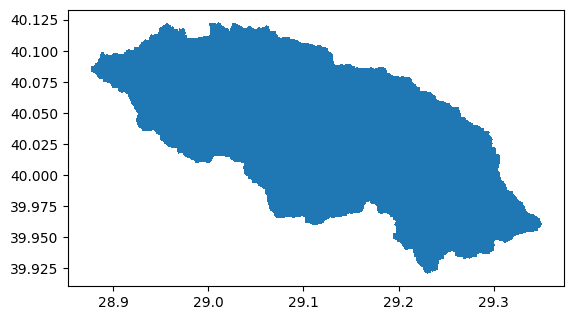

In [6]:
subbasin.plot()

In [7]:
watershed_id = "TR03"

In [8]:
def load_river_network(watershed_id, path2rivernetwork='../data/vector/river/'):
    """
    Loads a river network GeoDataFrame for a specific watershed ID.
    Args:
        watershed_id (str): Identifier for the watershed.
        path2rivernetwork (str, optional): Path to the directory containing river network data. 
            Defaults to '../data/vector/river/'.

    Returns:
        geopandas.GeoDataFrame: River network GeoDataFrame for the specified watershed.
    """
    # Construct the path to the river network file
    path = os.path.join(path2rivernetwork, f'{watershed_id}.geojson')

    # Load the river network data as a GeoDataFrame
    river_vector = gpd.read_file(path)

    return river_vector

In [10]:
def clip_river_network(river_network, subbasin_polygon, output_file):
    """
    Clips a river network GeoDataFrame using a subbasin polygon and saves the clipped river network as a new GeoJSON file.

    Args:
        river_network (geopandas.GeoDataFrame): Input river network GeoDataFrame.
        subbasin_polygon (geopandas.GeoDataFrame): Subbasin polygon GeoDataFrame.
        output_file (str): Path to the output clipped river network GeoJSON file.
    """
    # Clip the river network to the subbasin polygon
    clipped_river_network = gpd.clip(river_network, subbasin_polygon)

    # # Save the clipped river network as a new GeoJSON file
    # clipped_river_network.to_file(output_file, driver='GeoJSON')
    
    return clipped_river_network 

In [11]:
river_vector = load_river_network(watershed_id)

In [12]:
clipped_river_network = clip_river_network(river_vector, subbasin, 'output/river.geojson')

# TEST

## Read points

In [ ]:
from run_config import OUTLETS, WATERSHEDS, MODE

In [40]:
def read_outlets(path):
    """
    Checks if all column names in df are valid.

    Args:
        df: The Pandas DataFrame.
    Returns:
        None if all column names are in col_headers, an error otherwise.
    """
    points = pd.read_csv(path, sep='\t')
    col_headers = ['id', 'name', 'long', 'lat', 'area[km2]']
    missing_cols = []
    for col in points.columns:
        if col not in col_headers:
            missing_cols.append(col)

    if missing_cols:
        raise ValueError(
            f"The following columns are missing from the DataFrame: {missing_cols}. "
            f"Please add these columns to the DataFrame or update the column headers in {OUTLETS}.")
    else:
        return gpd.GeoDataFrame(points, geometry=gpd.points_from_xy(points.long, points.lat), crs = "EPSG:4326")

In [43]:
points = read_outlets(OUTLETS)

<Axes: >

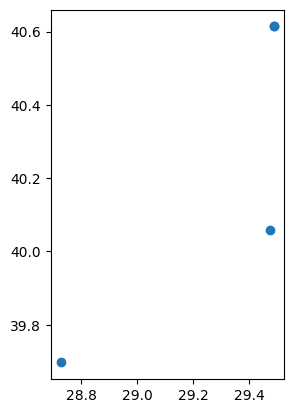

In [44]:
points.plot()

In [58]:
def join_watersheds2points(points, path2watershed):
    """
    Joins watershed information to points based on spatial relationship and returns the resulting GeoPandas DataFrame.

    Args:
        points (geopandas.GeoDataFrame): GeoPandas DataFrame containing the points.
        path2watershed (str): Path to the watershed GeoJSON file.

    Returns:
        pandas.DataFrame: DataFrame with the joined watershed information. Columns ['geometry', 'index_right', 'OBJECTID', 'Havza_Adı', 'Havza_Alan']
        are removed.

    """

    # Read watershed polygons from GeoJSON file
    watersheds = gpd.read_file(path2watershed)

    # Perform left join between points and watersheds
    joined = gpd.sjoin(points, watersheds, how='left', predicate='within')

    # Remove unnecessary columns
    columns_to_remove = ['geometry']
    joined.drop(columns=columns_to_remove, inplace=True)

    # Return the final pandas object
    return joined


In [60]:
points_labelled = join_watersheds2points(points, WATERSHEDS)
unique_watershed_ids = points_labelled["Watershed_ID"].unique()

In [65]:
for watershed in unique_watershed_ids[:1]:
    filtered_points_labelled  = points_labelled[points_labelled["Watershed_ID"] == watershed] 

In [66]:
filtered_points_labelled

,id,name,long,lat,area[km2],index_right,Watershed_ID,Watershed_Name,Watershed_Area
0,1,point_1,29.488,40.614,1000,1,TR02,Marmara,23520.24
2,3,point_3,29.488,40.614,350,1,TR02,Marmara,23520.24


In [68]:
for index, row in filtered_points_labelled.iterrows():
    coord = [row["long"], row["lat"]]
    
    
    

[29.488, 40.614]
[29.488, 40.614]


In [ ]:
points = read_outlets(OUTLETS)

# if MODE == "single":
    